# E3SM S2S input data

This notebook illustrates the input data loading used for the E3SM S2S forecast.

In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
# To execute the notebook update the data path to point to the e3sm directory extracted from the e3sm.tar.gz file.
data_path = Path("/home/simon/data/e3sm/")

## Original E3SM data

In [3]:
path = data_path / "training_data/input_vars.v2.LR.amip.non_ndg.eam.h1.latlon.1980-1981combo.nc"
e3sm_data = xr.load_dataset(path)

In [4]:
lons_e3sm = e3sm_data.lon.data
lats_e3sm = e3sm_data.lat.data

## E3SM training data

The ``E3SMS2SDataset`` implements a PyTorch dataset for the E3SM S2S forecast task. The dataset loads the dynamic data from the E3SM data as well as the static inputs from the prepared auxiliary files.

The target data for the model are daily precipitation anomalies in [mm h$^{-1}$].


In [5]:
from prithvi_precip.e3sm import E3SMS2SDataset

e3sm_dataset = E3SMS2SDataset(
    "/home/simon/data/3sm/training_data/",
    roi=(120, 45) # Lon and lat coordinate center of target region
)

> **Note**: The E3SMS2SDataset currently calculates the precipitation climatology on the fly upong construction, which incurs a certain overhead. To avoid the calculation at the beginning of the training it is possible to pass a NetCDF4 file containing the climatology of the ``PRECT`` field to the ``E3SMS2SDataset`` constructor.

In [7]:
input_data, target = e3sm_dataset[0]
list(input_data.keys())

['x',
 'static',
 'climate',
 'lead_time',
 'input_time',
 'x_regional',
 'climate_regional',
 'static_regional']

The model input data contains the following tensors:
  - ``x``:  Contains the E3SM data for the two input timesteps, shape=[2, 160, 180, 360]
  - ``static``:  Contains the static input data for the initialization time, shape=[8, 180, 360]
  - ``climate``:  The MERRA-2 climatology for all variables in ``x`` data for the target time, shape=[160, 180, 360]
  - ``lead_time``: The lead time in hours, shape=[]
  - ``input_time``: The time differene between the two input time steps, shape=[]
  - ``x_regional``: ``x`` restricted to target region, shape=[2, 160, 20, 20]
  - ``static_regional``: ``static`` restricted to target region, shape=[8, 180, 360]
  - ``climate_regional``: ``climate`` restricted to target region, shape=[160, 20 20]

> **Note:** The inputs named ``*_regional`` are specific to the regional variant of the Prithvi-WxC model. The other variables are identical to those used by the original model.

## MERRA-2 data

To ensure the input data matches the expected fields, the code below compares the E3SM input data to the original MERRA-2 variables.

The mapping of the E3SM variables to the Prithvi-WxC input data is implemented by the ``load_dynamic_data`` defined in the ``prithvi_precip.e3sm`` module.

The variables ``GWETROOT``, ``LAI``, ``SLP``, ``Z0M`` do not have a corresponding field in the E3SM data, so they are simply replaced by MERRA-2 climatology and ignored below.


In [28]:
merra_data = xr.load_dataset("/home/simon/data/e3sm/merra2_20060101000000.nc")

## Compare variables

The code blow displays 2D fields from the original E3SM data, the loaded input tensors, and the corresponding MERRA-2 fields.

In [34]:
import torch
from matplotlib.gridspec import GridSpec

def plot_fields(
    e3sm_field: xr.DataArray,
    input_data: torch.Tensor,
    merra_field: xr.DataArray):
    """
    Plots surface fields from original E3SM data ('e3sm_field'), the E3SM
    data converted to the Prithvi input ('input_data') and the original
    MERRA-2 data ('merra_field').
    """
    if e3sm_field is not None:
        vmax = max(np.nanmax(e3sm_field.data), np.nanmax(merra_field.data))
        vmin = min(np.nanmin(e3sm_field.data), np.nanmin(merra_field.data))
    else:
        vmax = np.nanmax(merra_field.data)
        vmin = np.nanmin(merra_field.data)
    gs = GridSpec(1, 4, width_ratios=[1.0, 1.0, 1.0, 0.075])
    fig = plt.figure(figsize=(20, 4))
    
    ax = fig.add_subplot(gs[0, 0])
    if e3sm_field is not None:
        lons = e3sm_field.lon
        lats = e3sm_field.lat
        ax.pcolormesh(lons, lats, e3sm_field, vmin=vmin, vmax=vmax, cmap="plasma")
        ax.set_title("(a) E3SM", loc="left")
        ax.set_xlabel(r"Longitude [$^\circ$ E]")
        ax.set_ylabel(r"Latitude [$^\circ$ N]")
        
        ax = fig.add_subplot(gs[0, 1])
        ax.pcolormesh(lons, lats, input_data, vmin=vmin, vmax=vmax, cmap="plasma")
        ax.set_title("(b) Input data", loc="left")
        ax.set_xlabel(r"Longitude [$^\circ$ E]")
        ax.set_ylabel(r"Latitude [$^\circ$ N]")
    else:
        ax = fig.add_subplot(gs[0, 1])
        ax.pcolormesh(input_data, vmin=vmin, vmax=vmax, cmap="plasma")
        ax.set_title("(b) Input data", loc="left")
        ax.set_xlabel(r"Longitude [$^\circ$ E]")
        ax.set_ylabel(r"Latitude [$^\circ$ N]")
    
    ax = fig.add_subplot(gs[0, 2])
    lons = merra_field.longitude
    lats = merra_field.latitude
    m = ax.pcolormesh(lons, lats, merra_field, vmin=vmin, vmax=vmax, cmap="plasma")
    ax.set_title("(c) MERRA 2", loc="left")
    ax.set_xlabel(r"Longitude [$^\circ$ E]")

    cax = fig.add_subplot(gs[0, 3])
    plt.colorbar(m, cax=cax)

### EFLUX -> LHFLX

Surface latent heat flux.

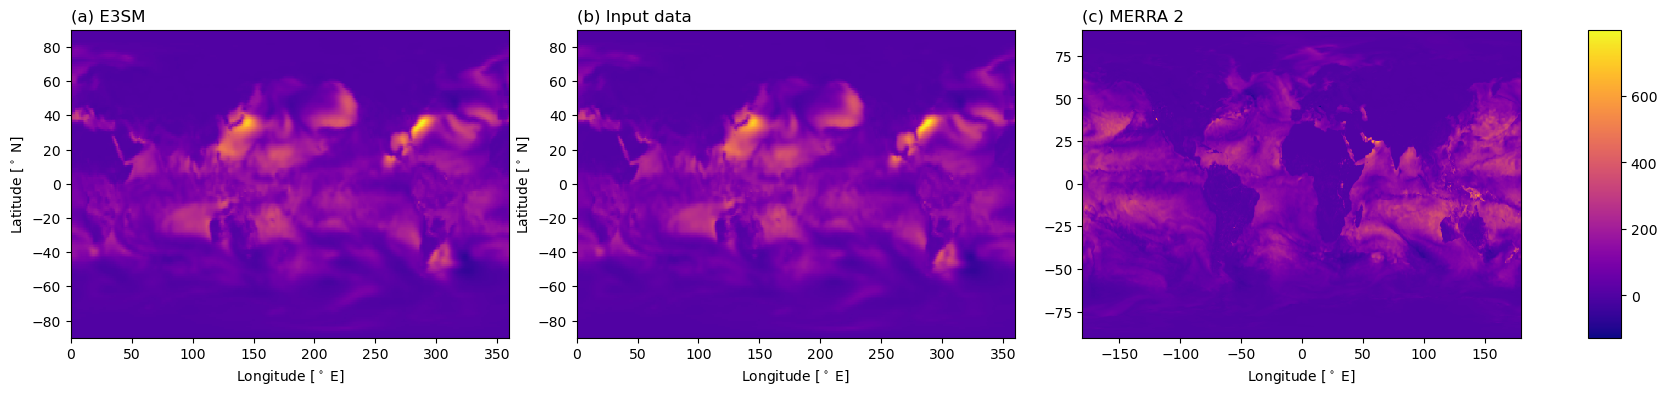

In [35]:
plot_fields(e3sm_data.LHFLX[0], input_data[0, 0], merra_data.EFLUX)

### HFLUX -> SHFLX

Surface sensible heat flux.

In [36]:
plot_fields(e3sm_data.SHFLX[0], input_data[0, 2], merra_data.HFLUX)

### LWGAB -> FLDS

Downwelling long wave flux at surface.

In [37]:
plot_fields(e3sm_data.FLDS[0], input_data[0, 4], merra_data.LWGAB)

### LWGEM -> FLDS - FLNS

Upweeling long wave flux at surface.

In [39]:
plot_fields(e3sm_data.FLDS[0] - e3sm_data.FLNS[0], input_data[0, 5], merra_data.LWGAB)

### LWTUP -> FLUT

Upwelling long wave flux at TOA.

In [40]:
plot_fields(e3sm_data.FLUT[0], input_data[0, 6], merra_data.LWTUP)

### PS -> PS

Surface pressure

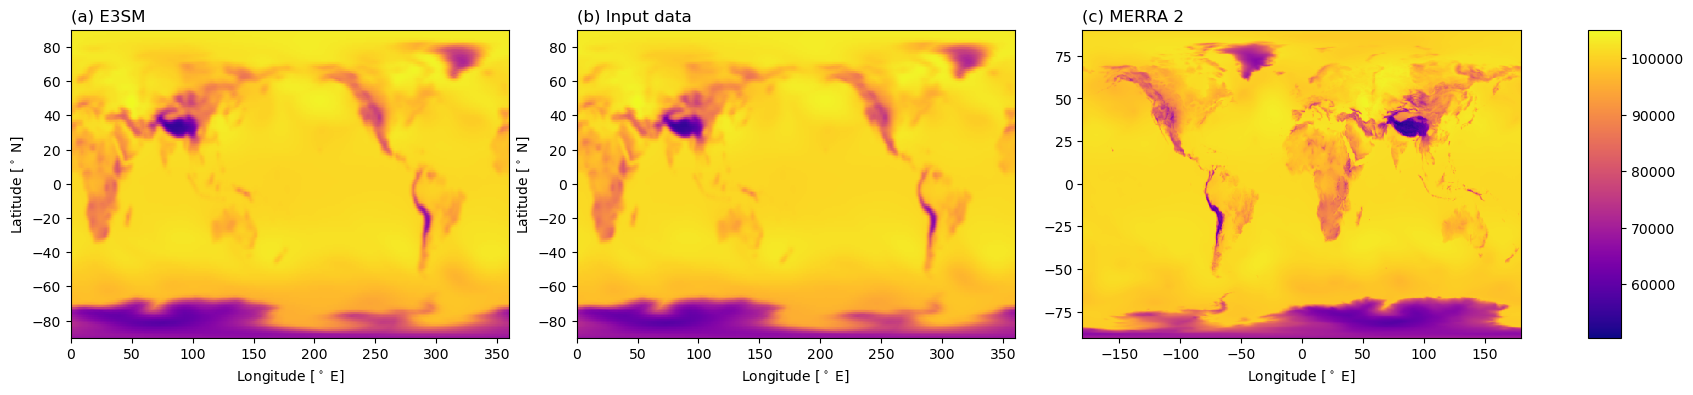

In [41]:
plot_fields(e3sm_data.PS[0], input_data[0, 7], merra_data.PS)

### QREFHT -> QV2M

Near-surface water vapor

In [42]:
plot_fields(e3sm_data.QREFHT[0], input_data[0, 8], merra_data.QV2M)

### SWGNT -> FSNS

Short-wave flux at surface

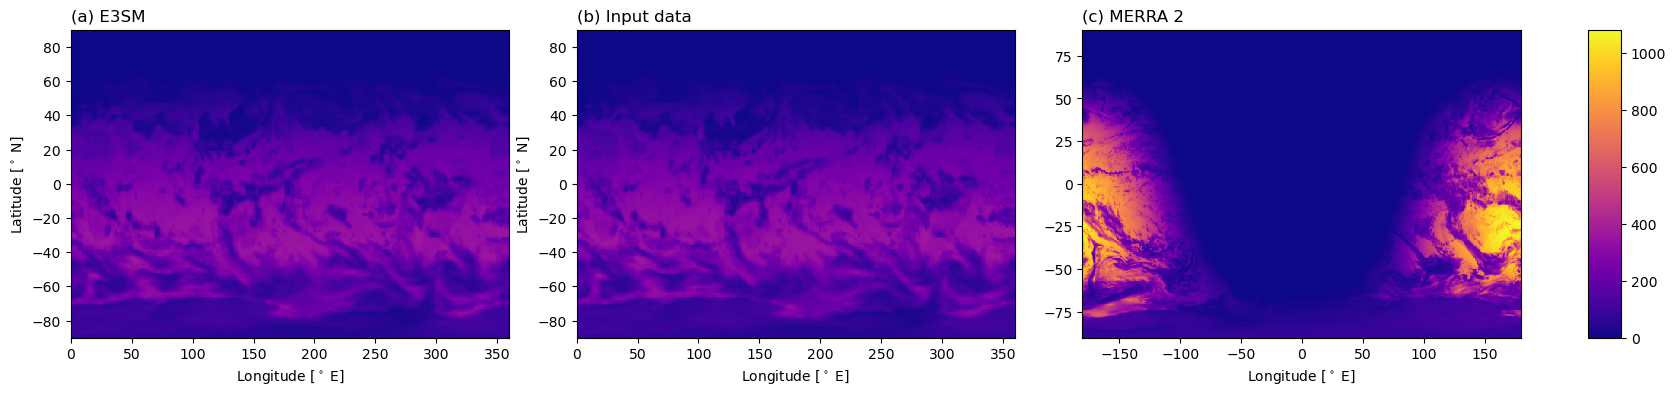

In [43]:
plot_fields(e3sm_data.FSNS[0], input_data[0, 10], merra_data.SWGNT)

### SWTNT -> FSNT

Short-wave flux at TOA

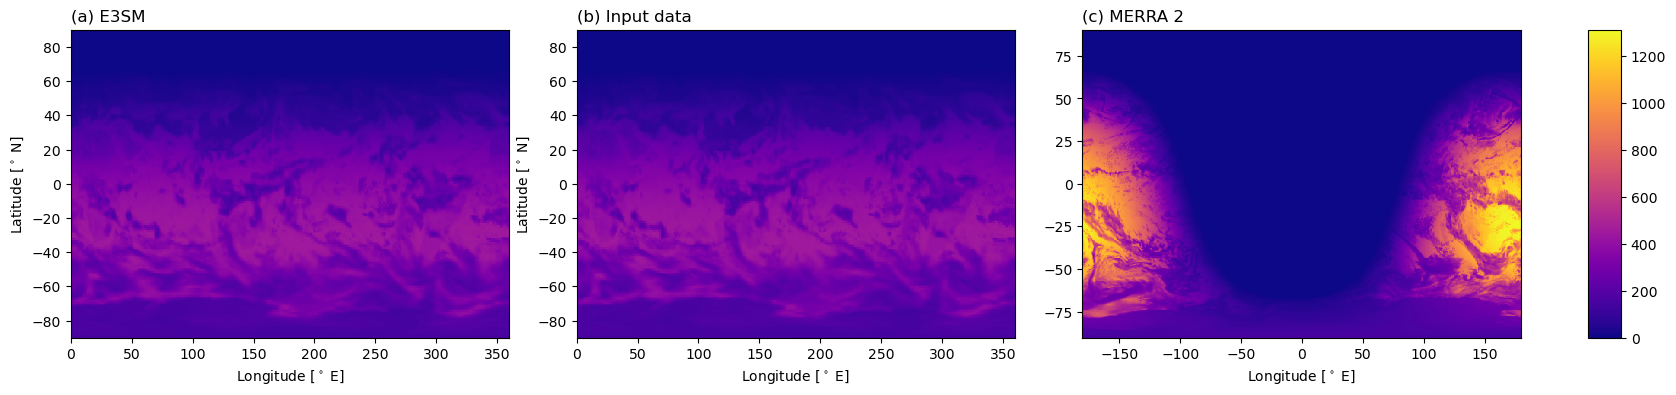

In [44]:
plot_fields(e3sm_data.FSNT[0], input_data[0, 11], merra_data.SWTNT)

### T2M -> TS

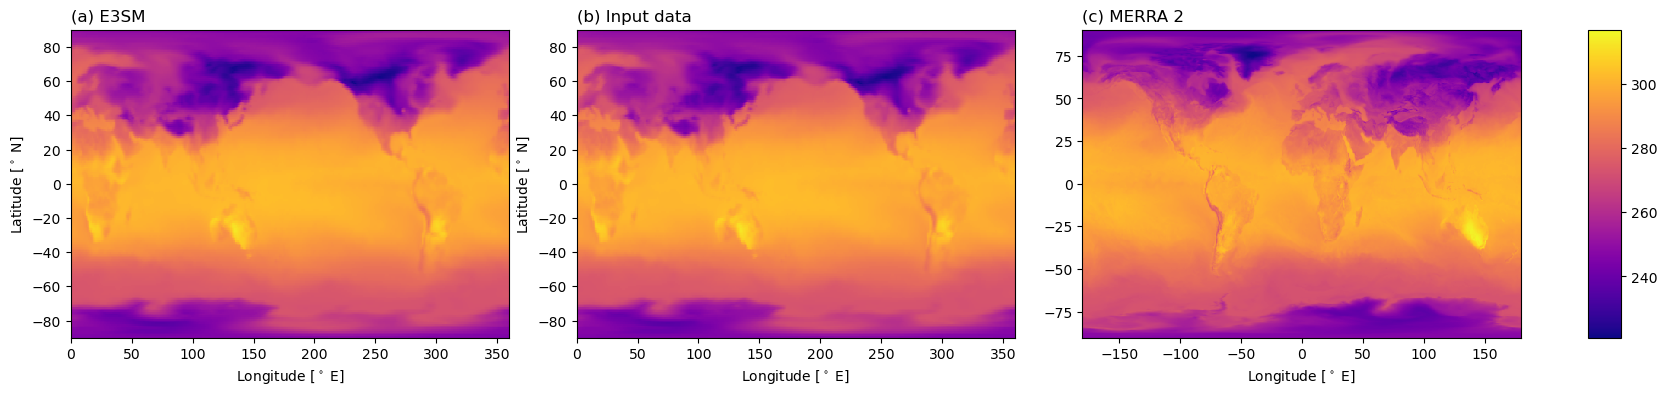

In [45]:
plot_fields(e3sm_data.TS[0], input_data[0, 12], merra_data.T2M)

### TQI -> TGCLDIWP

In [46]:
plot_fields(e3sm_data.TGCLDIWP[0], input_data[0, 13], merra_data.TQI)

### TQL -> TGCLDLWP

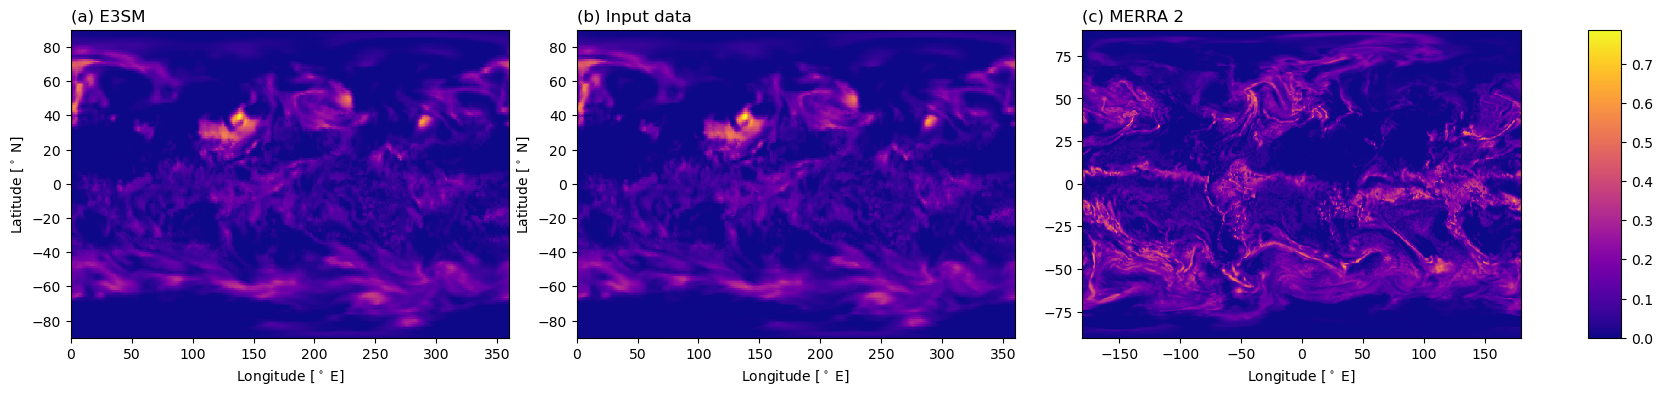

In [47]:
plot_fields(e3sm_data.TGCLDLWP[0], input_data[0, 14], merra_data.TQL)

### TQV -> TMQ

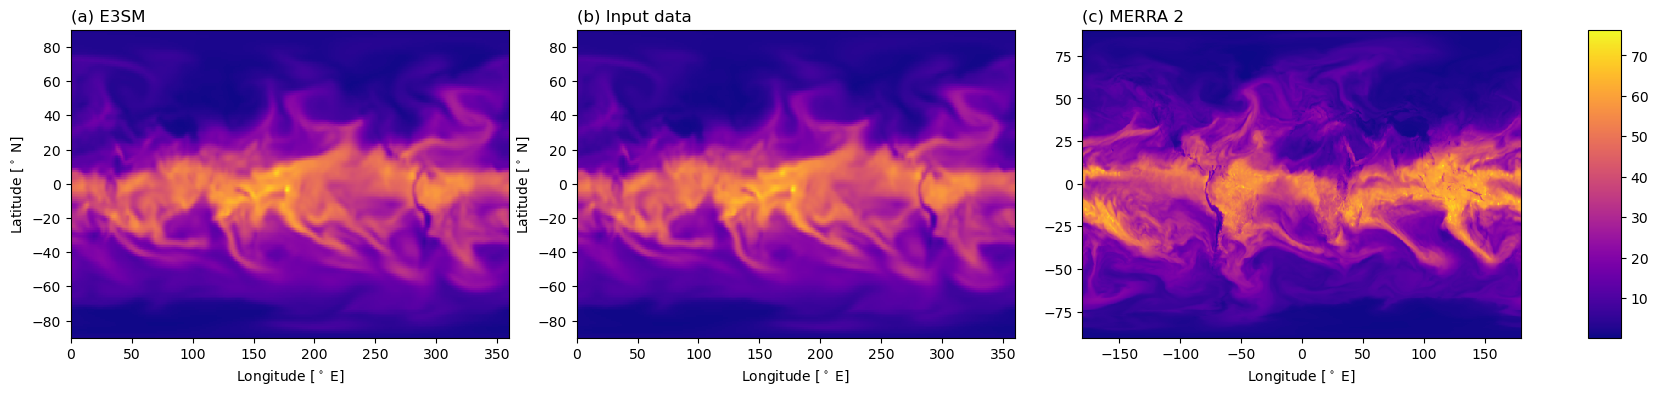

In [48]:
plot_fields(e3sm_data.TMQ[0], input_data[0, 15], merra_data.TQV)

### TS -> TS

In [49]:
plot_fields(e3sm_data.TS[0], input_data[0, 16], merra_data.TS)

### U10M -> UBOT

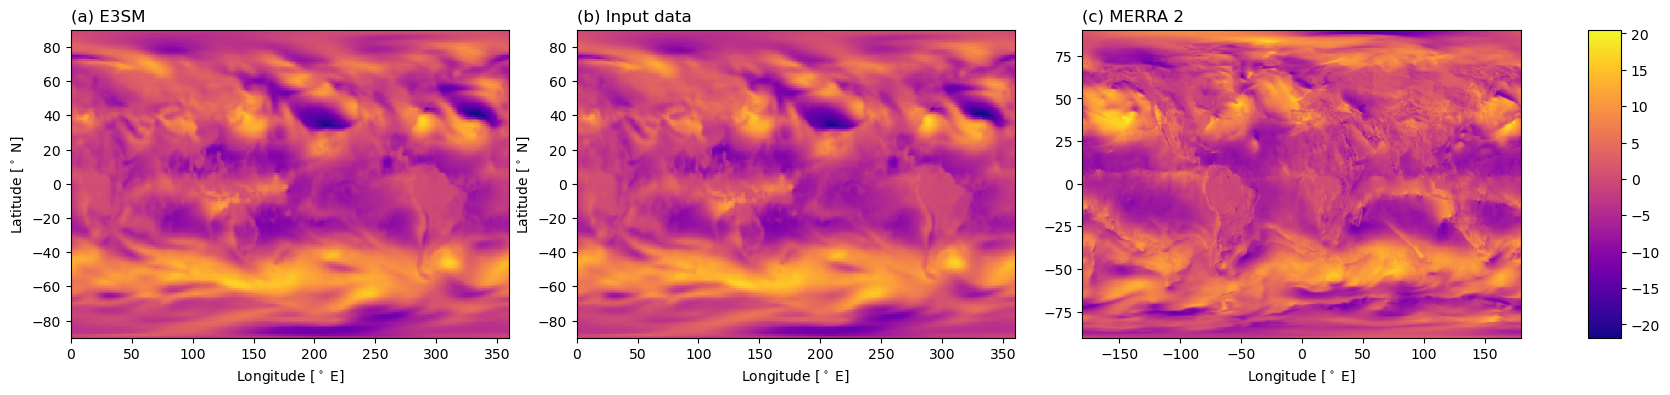

In [51]:
plot_fields(e3sm_data.UBOT[0], input_data[0, 17], merra_data.U10M)

### V10M -> VBOT

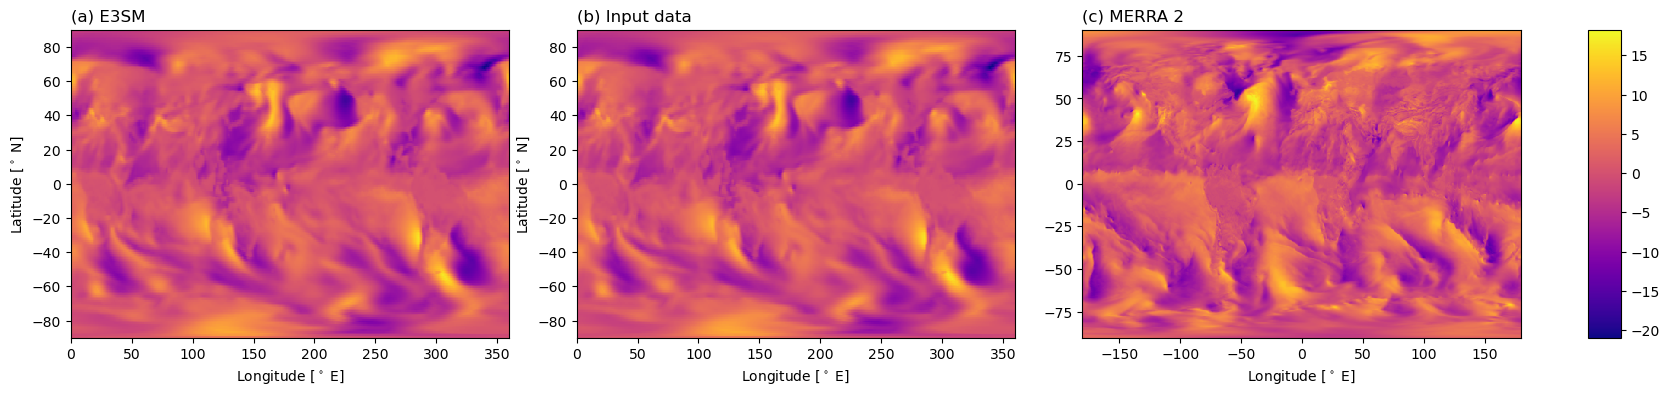

In [52]:
plot_fields(e3sm_data.VBOT[0], input_data[0, 18], merra_data.V10M)

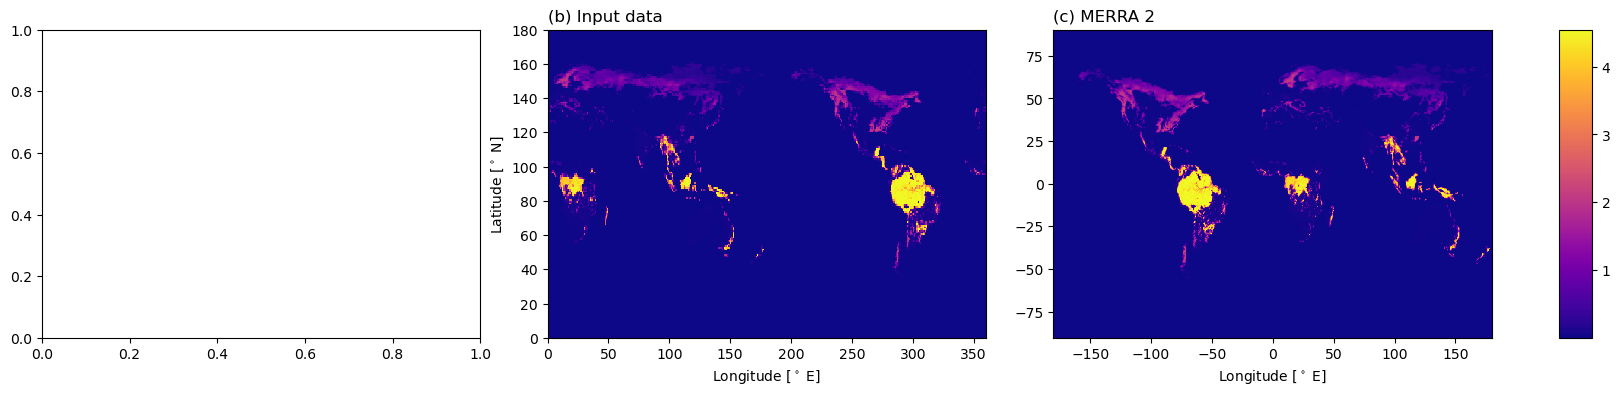

In [53]:
plot_fields(None, input_data[0, 19], merra_data.Z0M)

# Vertical variables

For the vertical variables, we plot meridional cross sections.

In [55]:
from matplotlib.gridspec import GridSpec

def plot_fields(input_data: torch.Tensor, merra_field: xr.Dataset) -> None:
    """
    Plot vertical cross-section of atmospheric input variables.

    Args:
        input_data: The converted E3SM input data.
        merra_field: The MERRA reference field.
    """
    vmin = min(np.nanmin(input_data), np.nanmin(merra_field))
    vmax = max(np.nanmax(input_data), np.nanmax(merra_field))

    gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.075])
    fig = plt.figure(figsize=(13, 4))
    
    ax = fig.add_subplot(gs[0, 0])
    ax.pcolormesh(input_data, vmin=vmin, vmax=vmax, cmap="plasma")
    ax.set_title("(a) Input data", loc="left")
    
    ax = fig.add_subplot(gs[0, 1])
    m = ax.pcolormesh(merra_field, vmin=vmin, vmax=vmax, cmap="plasma")
    ax.set_title("(b) MERRA data", loc="left")
        
    cax = fig.add_subplot(gs[0, 2])
    plt.colorbar(m, cax=cax)

### CLOUD

The ``CLOUD`` field is emulated by taking summing ``QI`` and ``QL`` fields (see below)  normalized by the respective climatological column maximum and capping at 1.0.

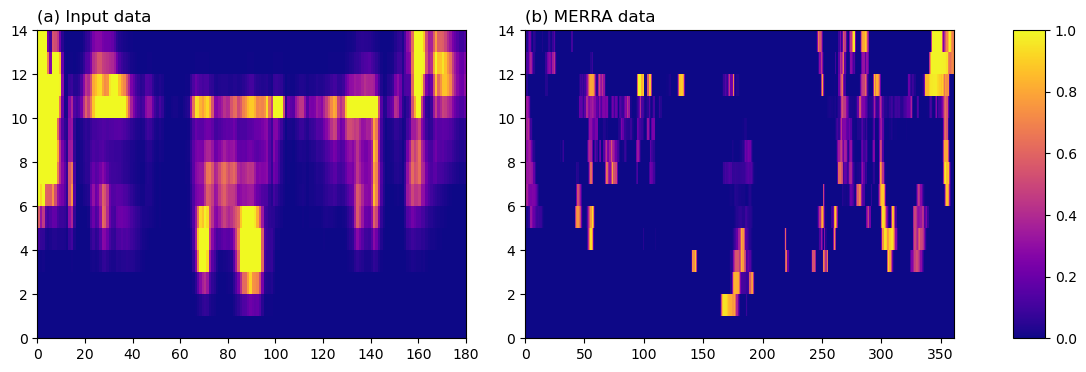

In [57]:
ind = 0
plot_fields(input_data[0, 20 + 14*ind: 20 + 14*(ind + 1), :,180], merra_data.CLOUD[:, :, 576 // 2])

## Height

The heigh field is loaded from the climatology.

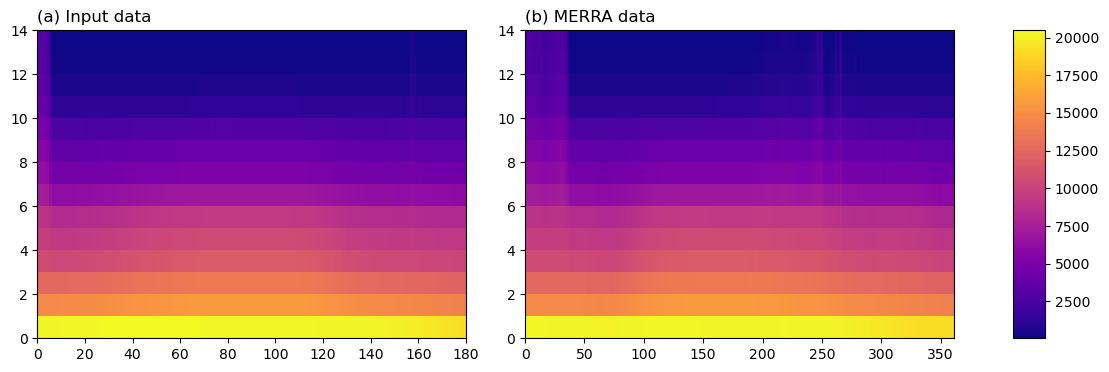

In [65]:
ind = 1
plot_fields(input_data[0, 20 + 14*ind: 20 + 14*(ind + 1), :,180], merra_data.H[:, :, 576 // 2])

## Omega

The ``OMEGA`` field is emulated by taking the climatological profiles and scaling them to match the E3SM ``OMEGA500`` variable.

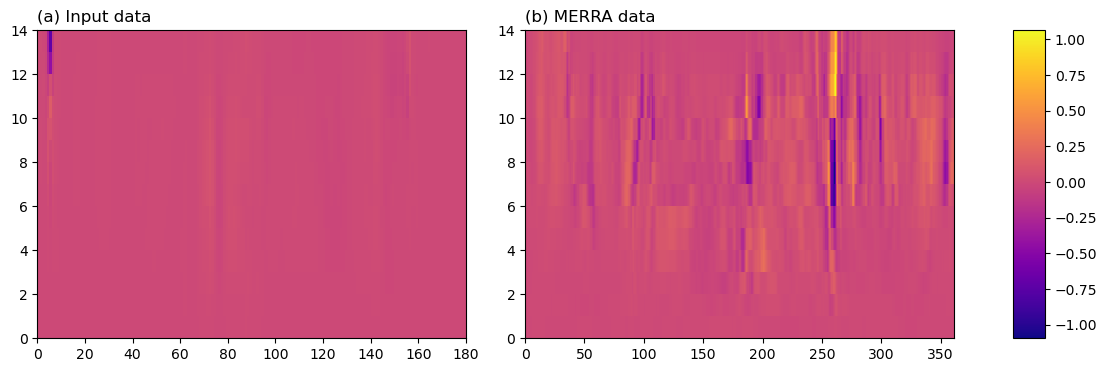

In [66]:
ind = 2
plot_fields(input_data[0, 20 + 14*ind: 20 + 14*(ind + 1), :,180], merra_data.OMEGA[:, :, 576 // 2])

## PL

The pressure is taken from the climatology

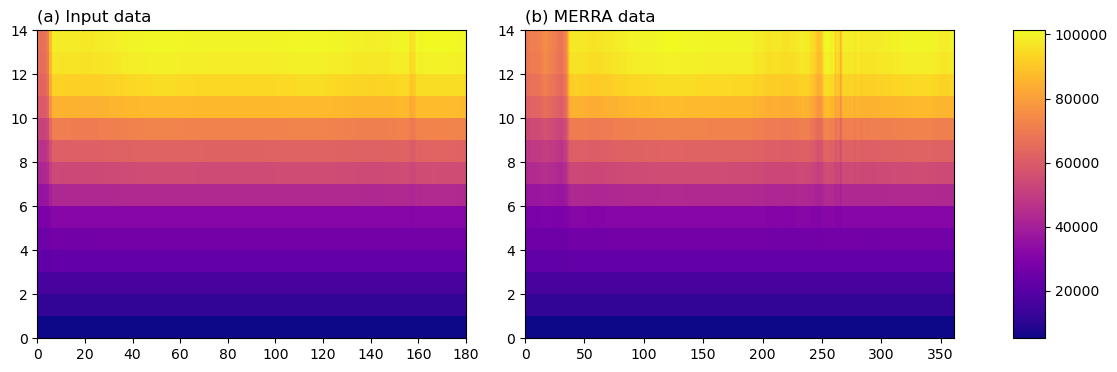

In [67]:
ind = 3
plot_fields(input_data[0, 20 + 14*ind: 20 + 14*(ind + 1), :,180], merra_data.PL[:, :, 576 // 2])

## QI

The QI field is emulated by scaling climatological profiles to match ``TGCLDIWP``.

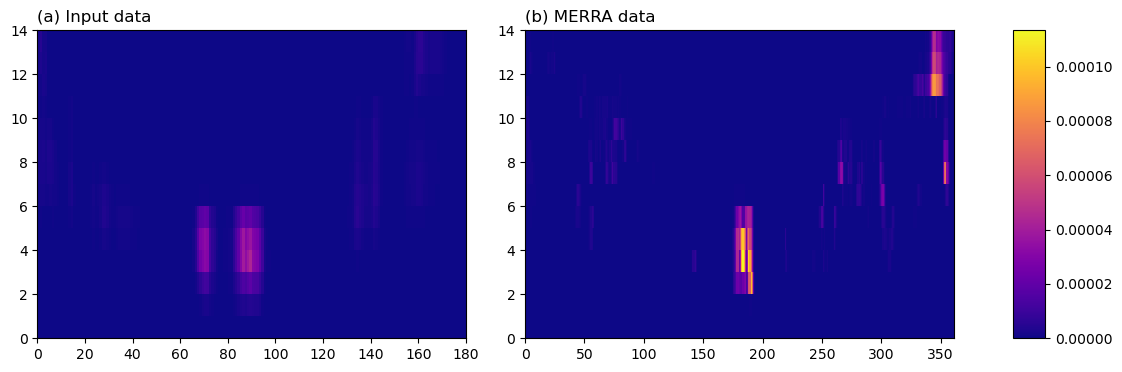

In [68]:
ind = 4
plot_fields(input_data[0, 20 + 14*ind: 20 + 14*(ind + 1), :,180], merra_data.QI[:, :, 576 // 2])

## QL

The QL field is emulated by scaling climatological profiles to match ``TGCLDLWP``.

In [69]:
ind = 5
plot_fields(input_data[0, 20 + 14*ind: 20 + 14*(ind + 1), :,180], merra_data.QL[:, :, 576 // 2])

# QV

The QV field is emulated by scaling climatological profiles to match ``TMQ``.

In [63]:
ind = 6
plot_fields(input_data[0, 20 + 14*ind: 20 + 14*(ind + 1), :,180], merra_data.QV[:, :, 576 // 2])

## T

The T field is emulated by scaling climatological profiles to match ``T250`` and using ``T050``, ``T100``, ``T150``, ``T200`` to set the corresponding levels in the ``T`` field.

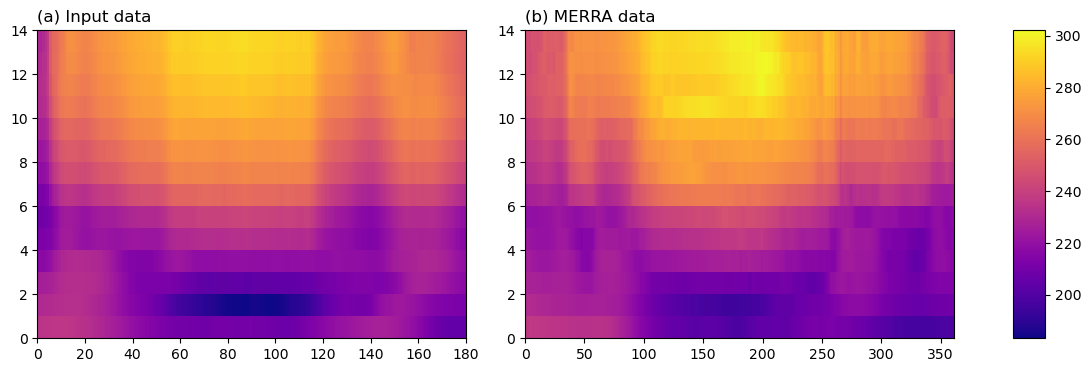

In [64]:
ind = 7
plot_fields(input_data[0, 20 + 14*ind: 20 + 14*(ind + 1), :,180], merra_data.T[:, :, 576 // 2])

## U

A similar approch is taken for ``U``, i.e., scale the climatological wind profiles to match the lowest value in the E3SM data ``U850`` and use the remaining values to fill the corresponding levels in the field.

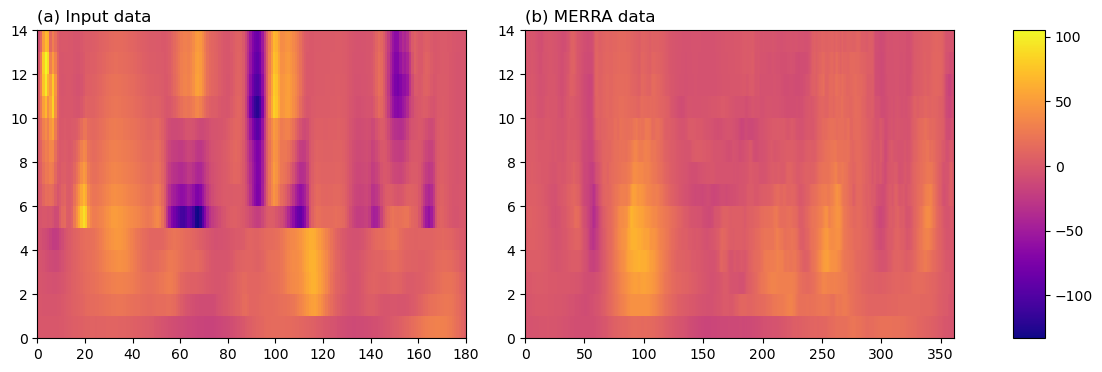

In [72]:
ind = 8
plot_fields(input_data[0, 20 + 14*ind: 20 + 14*(ind + 1), :,180], merra_data.U[:, :, 576 // 2])

## V

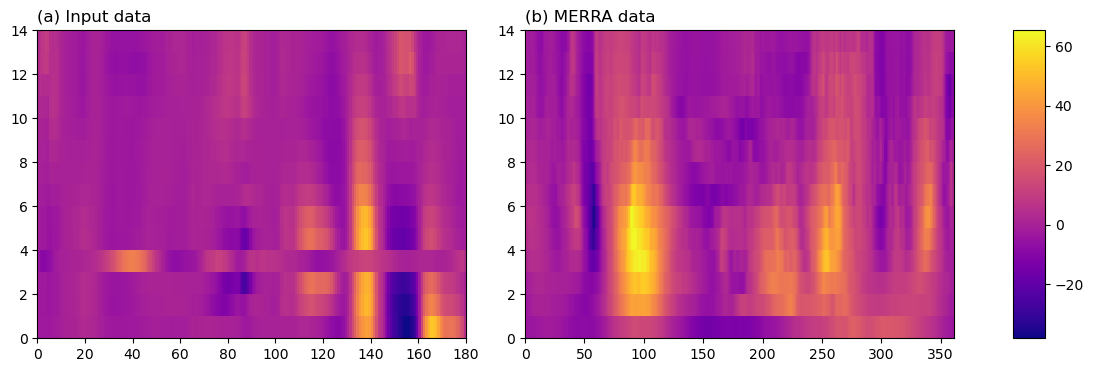

In [73]:
ind = 9
plot_fields(input_data[0, 20 + 14*ind: 20 + 14*(ind + 1), :,180], merra_data.U[:, :, 576 // 2])